# 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from fastqaoa.utils import styling

from problems import IntegerKnapsack

from circuit_lengths import add_lengths_to_df
from regressor import fit_multi

styling.set_my_style()

In [3]:
df = pd.read_feather("../../results/int_main2.feather")

df = df.query("qaoa != 'qpe'")


df["method"] = df.qaoa + "_" + df.cost
replacer = {"masked_cost_default": "IF-QAOA", "quad_penalty_cost_masked_cost": "Virtual Penalty", "quad_penalty_full_problem_masked_cost": "Slack Penalty"}
clean_names = {"depth": "QAOA Layer $p$", "rnd_approx_ratio": "RAAR", "tts": "TTS [CLOPS]", "p_opt": r"$p_\text{opt}$", "repeats": "Repeats", "p_999": r"$p_{99.9\%}$", "p_99": r"$p_{99\%}$", "p_9": r"$p_{90\%}$", "n_qubits": "Problem Size $N$"}
df["Method"] = df.method.replace(replacer)


df = df[np.logical_not(np.isnan(df.n_qubits))]
# df = df[np.logical_or(df.cost == "masked_cost", df.qaoa == "masked_cost")]

df["depth"] = df.depth.astype(int)
df["problem_id"] = df.problem_id.astype(int)

df = df.drop(df.query("n_qubits == 20 and depth > 32").index)

In [4]:
depths = df.depth.unique()

df["fitting_depth"] = df.n_qubits.transform(lambda x: depths[np.argmin(np.abs(x - depths))])

Text(0, 0.5, 'RAAR')

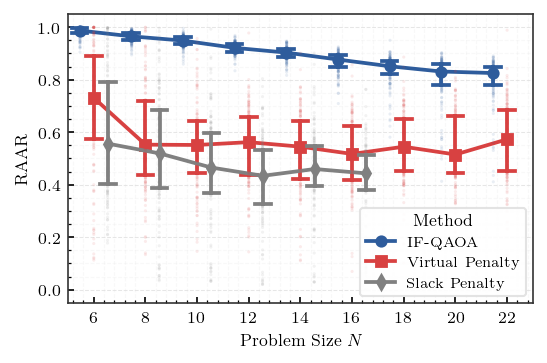

In [5]:
fig, _ = styling.subplots()
sns.pointplot(df.query("depth == 16"), x="n_qubits", y="rnd_approx_ratio", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("depth == 16"), x="n_qubits", y="rnd_approx_ratio", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel("Problem Size $N$")
plt.ylabel("RAAR")

Text(0, 0.5, 'RAAR')

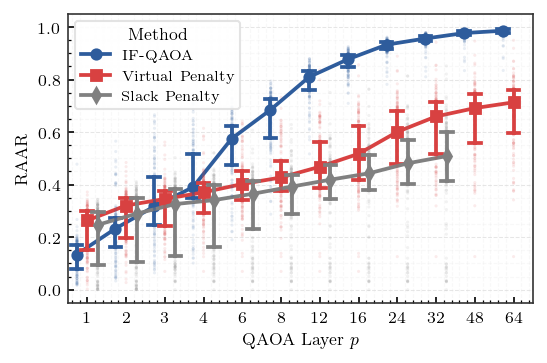

In [6]:
fig, _ = styling.subplots()
sns.pointplot(df.query("n_qubits == 16"), x="depth", y="rnd_approx_ratio", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("n_qubits == 16"), x="depth", y="rnd_approx_ratio", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel("QAOA Layer $p$")
plt.ylabel("RAAR")

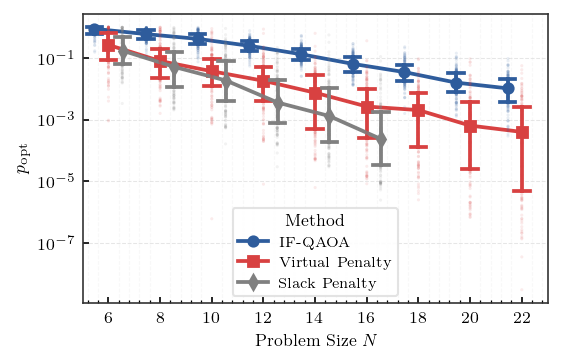

In [7]:
fig, ax = styling.subplots()
sns.pointplot(df.query("depth == 16"), x="n_qubits", y="p_opt", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("depth == 16"), x="n_qubits", y="p_opt", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel(clean_names[ax.get_xlabel()])
plt.ylabel(clean_names[ax.get_ylabel()])
plt.yscale("log")

In [8]:
add_lengths_to_df(df, IntegerKnapsack)

In [9]:
df["repeats"] = np.ceil(np.log(0.01) / np.log(1 - df.p_opt))
df["tts"] = df.clops * df.repeats
df["log_tts"] = np.log10(df.tts)

df_fit = fit_multi(df, x="n_qubits", y="log_tts", groupby=["method", "depth"])

df_opt = df.groupby(["problem_id", "method", "n_qubits"], group_keys=False).apply(lambda x: x.iloc[x.tts.argmin()], include_groups=False).reset_index()
df_opt_fit = fit_multi(df_opt, x="n_qubits", y="log_tts", groupby=["method"])

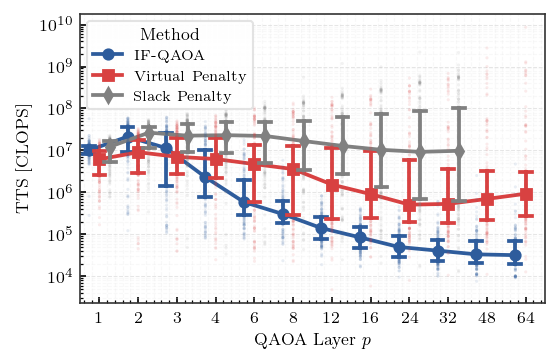

In [10]:
fig, ax = styling.subplots()
sns.pointplot(df.query("n_qubits == 16"), x="depth", y="tts", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("n_qubits == 16"), x="depth", y="tts", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel(clean_names[ax.get_xlabel()])
plt.ylabel(clean_names[ax.get_ylabel()])
plt.yscale("log")

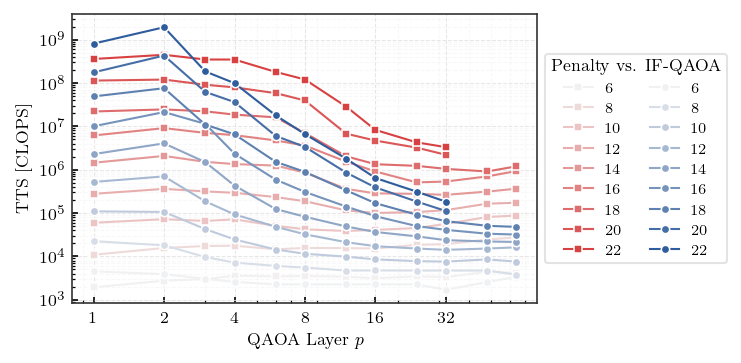

In [11]:
_, ax = styling.subplots()

# sns.lineplot(df2.query("qaoa == 'masked_cost'"), x="depth", y="adj_clops", hue="n_qubits", errorbar=("pi", 50), marker="o", palette="Blues")

q = 0.5

p = styling.shades(9, 1)
sns.lineplot(df.query("qaoa == 'quad_penalty_cost'"), x="depth", y="tts", hue="n_qubits", palette=p, legend=True, marker="s", markersize=4, estimator=lambda x: np.quantile(x, q), errorbar=None)

p = styling.shades(9, 0)
tgt = sns.lineplot(df.query("qaoa == 'masked_cost'"), x="depth", y="tts", hue="n_qubits", palette=p, marker="o", markersize=4, estimator=lambda x: np.quantile(x, q), errorbar=None)

plt.yscale("log")
plt.ylabel(clean_names[ax.get_ylabel()])

plt.xlabel(clean_names[ax.get_xlabel()])

# plt.xlim(0, 32)
x, y = ax.get_legend_handles_labels()
ax.legend_.remove()

plt.xscale("log")

plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])


ax.legend(x + x, y, ncols=2, title="Penalty  vs.  IF-QAOA", loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("plots/int_clops.pdf", bbox_inches="tight", transparent=True)


,slope,intercept,rvalue,lower,upper,scale
method,,,,,,
masked_cost_default,0.127234,2.482496,0.799785,0.123551,0.130917,1.340398
quad_penalty_cost_masked_cost,0.224181,1.958151,0.681972,0.215323,0.233038,1.675639
quad_penalty_full_problem_masked_cost,0.306349,1.439103,0.734745,0.293293,0.319404,2.024644


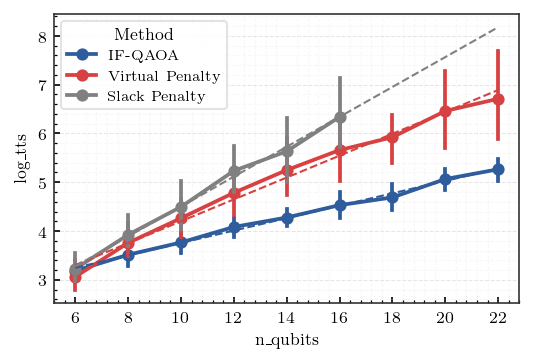

In [12]:
styling.subplots()
sns.pointplot(df_opt, x="n_qubits", y="log_tts", hue="Method", errorbar=("pi", 50))

def plot_fit(d):
    x  = np.arange(6, 23, 2)
    plt.plot(np.arange(len(x)),  d.intercept + d.slope * x, linestyle="--")

df_opt_fit.apply(plot_fit, axis=1)
df_opt_fit["scale"] = 10 ** df_opt_fit.slope
df_opt_fit

method                                 depth
masked_cost_default                    32       None
quad_penalty_cost_masked_cost          32       None
quad_penalty_full_problem_masked_cost  32       None
dtype: object

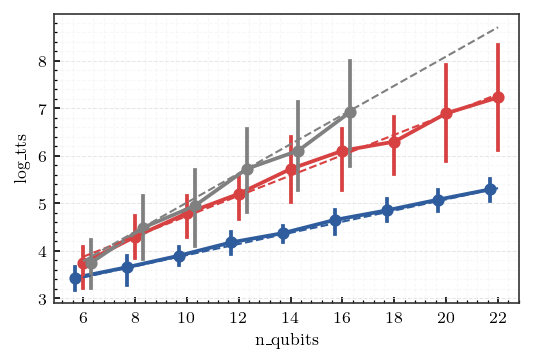

In [13]:
# qp.plot_setup()

styling.subplots()

sns.pointplot(df.query("depth==32"), x="n_qubits", y="log_tts", hue="method", dodge=0.3, legend=False, errorbar=("pi",50))
# x = np.arange(6, 24, 2)
# plt.plot(x, (0.2829 + 0.005) * x + 1.04)

# plt.yscale("log")



x = np.linspace(6, 22, 100)
xi = np.linspace(0, (22 - 6) / 2, 100)
def plot_fit(d):
    plt.plot(xi,  d.intercept + d.slope * x, linestyle="--")

df_fit.query("depth == 32").apply(plot_fit, axis=1)

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_27820/676558011.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfx.groupby("method").apply(plot_method)


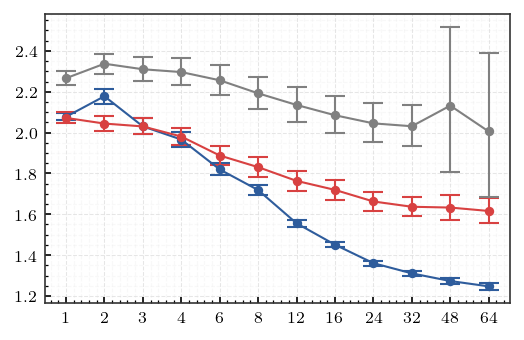

In [14]:
styling.subplots()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(10 ** (x[["lower", "upper"]].to_numpy().T) - 10 ** (x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), 10 ** x.slope, yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_27820/471254791.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df_opt.query("method == '' and n_qubits < 20"), x="depth_idx", hue="n_qubits", palette=palette, )


TypeError: 'NoneType' object is not iterable

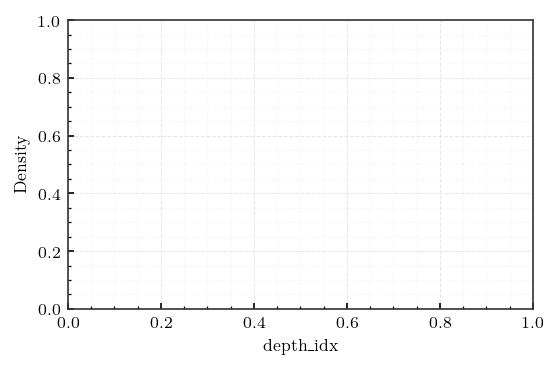

In [15]:
_, ax = styling.subplots()

depth_to_idx = list(sorted(df.depth.unique()))

df_opt["depth_idx"] = df_opt.depth.apply(lambda x: depth_to_idx.index(x))

palette = styling.shades(7)
# sns.histplot(df_opt.query("method == 'masked_cost_default' and n_qubits < 20"), x="depth_idx", bins=np.arange(0, len(depth_to_idx) + 1 ), hue="n_qubits", alpha=0.4, element="step", palette=palette)
sns.kdeplot(df_opt.query("method == '' and n_qubits < 20"), x="depth_idx", hue="n_qubits", palette=palette, )
ax.grid(False, which="minor")
ax.grid(False)

ax.set_xticks(np.arange(len(depth_to_idx)) + 0.5, depth_to_idx)
np.arange(0, len(depth_to_idx) + 1 )

In [ ]:
dfx = df[df.qaoa == "quad_penalty_cost"]
dfx = dfx.query("depth == 16")
dfx["log_penalty"] = np.log10(dfx.set_penalty)

sns.stripplot(dfx, x="n_qubits", y="p_opt", hue="log_penalty", palette="coolwarm", dodge=True, jitter=False)
plt.yscale("log")

dfx[["weight_ratio", "p_opt", "approx_ratio", "n_qubits", "log_penalty"]].corr()

In [ ]:
instances = IntegerKnapsack.get_instances()[10][:64]

dat = []
for prb in instances:
    r = prb.max_capacity / sum(prb.weights)
    dg = prb.kickback_cost().scale_between_sym()
    dat += [{"id": prb.id, "weight_ratio": r, "value": v} for v in dg.to_numpy()]

In [ ]:
df_prb = pd.DataFrame(dat)
df_prb["wrr"] = df.weight_ratio.transform(lambda x: np.round(x, 1))

In [ ]:
# sns.histplot(df_prb, x="value", hue="id", alpha=0.1, palette="muted")

In [ ]:
dfx.query("set_penalty < 0.02").set_penalty

In [ ]:
# interesting instances: 40, 44, 45, 
prb = IntegerKnapsack.get_instances()[16][48]

cost, constr = prb.diagonalized()
norm = np.abs(cost.min_val)
cost = cost / norm

cost_arr = cost.to_numpy()

feas = (constr >= 0).to_numpy()

dfu = pd.DataFrame(np.stack([cost_arr, feas]).T, columns=["v", "c"])

In [ ]:
sns.histplot(dfu, x="v", hue="c")
# plt.xlim(-1, -0.8)
# plt.ylim(0, 200)

In [ ]:
qpc = prb.quad_penalty_cost() / norm
print(prb._penalty)

dfu2 = pd.DataFrame(np.stack([qpc.to_numpy(), feas]).T, columns=["v", "c"])

In [ ]:
sns.histplot(dfu2, x="v", hue="c")
# plt.xlim(-0.8, -0.6)
# plt.ylim(0, 200)

In [ ]:
prb._penalty

In [ ]:
df["log_penalty"] = df.set_penalty.transform(lambda x: x if np.isnan(x) else np.log10(x))

In [ ]:
df.method

## Correlation of instance types

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(7, 2), dpi=120, facecolor="white")
dfp = df.pivot(index=["problem_id", "n_qubits", "depth"], columns="qaoa")
# dfp = dfp.query("n_qubits >= 10")
# dfp["weight_ratio"] = dfp[("weight_ratio", "masked_cost_default")]
# dfp["set_penalty"] = dfp[("set_penalty", "quad_penalty_cost_default")]
# plt.yscale("log")
# plt.xscale("log")


c = "tts"
default = lambda x: dfp[(x, "quad_penalty_cost")]

depths = [2, 4, 8, 16]


plots = []
for d, a in zip(depths, ax):
    p = sns.scatterplot(dfp.query("depth == @d"), x=(c, "masked_cost"), y=(c, "quad_penalty_cost"), hue=default("weight_ratio"), alpha=0.5, legend=False, palette="coolwarm", ax=a)
    a.set_title(f"$p = {d}$")
    plots.append(p)

for a in ax:
    a.plot([1e2, 1e10], [1e2, 1e10], color="k", alpha=0.5)
    #a.set_ylim((0, 1))
    #a.set_xlim((0, 1))
    a.set_yscale("log")
    a.set_xscale("log")
    # a.set_xticks([0.2, 0.5, 0.8])
    a.set_xlabel("$p_\mathrm{opt}$ IF-QAOA")

for a in ax[1:]:
    a.axes.yaxis.set_ticklabels([])
    a.set_ylabel(None)
ax[0].set_ylabel(r"$p_\mathrm{opt}$  Penalty ($\mathcal{D}$)")

plt.subplots_adjust(wspace=0, hspace=0)

ser = default("log_penalty")

norm = plt.Normalize(ser.min(), ser.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

cb_ax = fig.add_axes([.91,.124,.015,.754])
fig.colorbar(sm, orientation='vertical', cax=cb_ax, label="weight ratio", ticks=[0.21, 0.4, 0.6, 0.8])

cb_ax.set_yticks([0.21, 0.4, 0.6, 0.8], [0.2, 0.4, 0.6, 0.8])

# fig.tight_layout()

plt.savefig("plots/int_raar_cmp_weight_ratio.pdf", bbox_inches="tight", transparent=True)

In [ ]:
# qp.plot_setup(aspect_ratio=1)
styling.set_my_style()

c = "energy"
sns.scatterplot(dfp, x=(c, "masked_cost_default"), y=(c, "quad_penalty_cost"), alpha=0.8, legend=False, palette="crest")
plt.plot([0, 1], [0, 1], color="k")

plt.ylim((0, 1))
plt.xlim((0, 1))

plt.xlabel("Indicator Function RAAR")
plt.ylabel("Penalty RAAR")


In [ ]:
sns.pointplot(df.query("qaoa == 'masked_cost'"), x="depth", y="log_adj_clops", hue="n_qubits", errorbar=("pi", 75), dodge=0.3)

In [ ]:
df.query("n_qubits == 22").clops.max()

# Deeper optimal scaling analysis

<Axes: xlabel='pdepth', ylabel='gammas'>

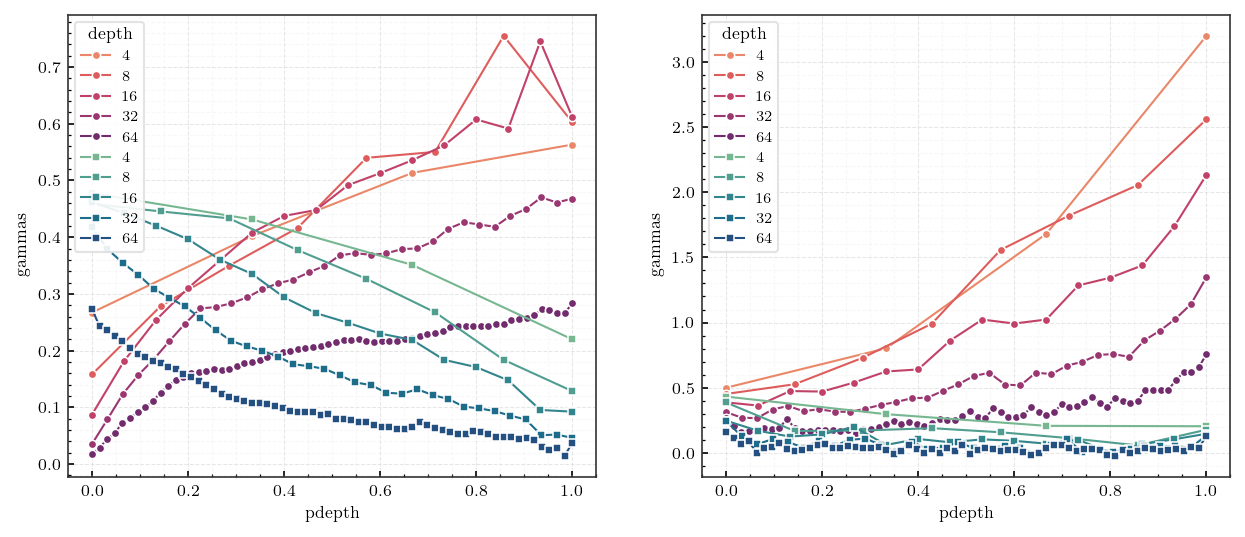

In [27]:
fig, ax = styling.subplots(1, 2, figsize=(10, 4))

dfx = df[["problem_id", "n_qubits", "depth", "qaoa", "betas", "gammas"]].copy()

dfx = dfx.query("n_qubits == 6")

dfx["pdepth"] = dfx.depth.transform(lambda d: np.linspace(0, 1, d))

dfx = dfx.explode(column=["betas", "gammas", "pdepth"])

depths = [4, 8, 16, 32, 64]

dfx = dfx.query("depth in @depths")

sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="gammas", hue="depth", palette=sns.color_palette("flare", len(depths)), marker="o", markersize=4, errorbar=None)
sns.lineplot(dfx.query("qaoa == 'masked_cost'"), ax=ax[0], x="pdepth", y="betas", hue="depth", palette=sns.color_palette("crest", len(depths)), marker="s", markersize=4, errorbar=None)

sns.lineplot(dfx.query("qaoa == 'quad_penalty_cost'"), ax=ax[1], x="pdepth", y="gammas", hue="depth", palette=sns.color_palette("flare", len(depths)), marker="o", markersize=4, errorbar=None)
sns.lineplot(dfx.query("qaoa == 'quad_penalty_cost'"), ax=ax[1], x="pdepth", y="betas", hue="depth", palette=sns.color_palette("crest", len(depths)), marker="s", markersize=4, errorbar=None)

#ax[1].set_ylim((0, 1))

# sns.lineplot(dfx.query("and n_qubits == 16 and qaoa == 'masked_cost'"), x="pdepth", y="gammas")

In [ ]:
s
